## STATS 202 Kaggle In Class Competition: Property values

### Data
* 9 predictors: ID, YearBuild, SqFt, Story, Acres, Baths, Fireplaces, Zip
* 1 response: Value
* number of observations: 90
* missing values 
* candidate learning algorithms:
 * parameteric
     * multiple linear regression
     * PCR
     * Ridge, Lasso
 * nonparametric
     * spline
     * nearest neighbor
     * decision tree
     * SVM

In [2]:
library(dplyr)
library(ggplot2)
library(reshape2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
data = read.csv('../data/train.csv', header=T)
testInput = read.csv('../data/test.csv', header=T)
head(data)
summary(testInput)
dim(data)

ID,YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip,Value
1,1990,2102,1.0,0.77,NA,1,27603,203200
2,1986,1740,1.5,0.06,3,1,27604,119096
3,1955,795,1.0,0.30,1,0,27610,71666
4,1983,1152,1.0,0.68,2,0,27616,131103
5,2003,1404,1.0,39.38,2,0,27519,4904102
6,1924,1829,1.5,0.25,3,1,27607,496425


       ID          YearBuilt         SqFt          Story           Acres       
 Min.   : 1.00   Min.   :1947   Min.   : 900   Min.   :1.000   Min.   :0.0300  
 1st Qu.: 3.25   1st Qu.:1967   1st Qu.:1068   1st Qu.:1.000   1st Qu.:0.1725  
 Median : 5.50   Median :1984   Median :1485   Median :1.000   Median :0.2150  
 Mean   : 5.50   Mean   :1977   Mean   :1571   Mean   :1.375   Mean   :0.2470  
 3rd Qu.: 7.75   3rd Qu.:1987   3rd Qu.:1856   3rd Qu.:1.938   3rd Qu.:0.2825  
 Max.   :10.00   Max.   :1995   Max.   :2678   Max.   :2.000   Max.   :0.5600  
     Baths         Fireplaces        ZIP       
 Min.   :1.000   Min.   :0.00   Min.   :27513  
 1st Qu.:1.625   1st Qu.:0.25   1st Qu.:27560  
 Median :2.000   Median :1.00   Median :27608  
 Mean   :2.050   Mean   :0.70   Mean   :27586  
 3rd Qu.:2.500   3rd Qu.:1.00   3rd Qu.:27612  
 Max.   :3.000   Max.   :1.00   Max.   :27616  

[1] 90  9

In [4]:
# impute the NA value in the bath by its average
data$Baths[is.na(data$Baths)] = round(mean(data$Baths, 
                                             na.rm=T),0)
data = data[,-1]
data$Zip = as.factor(data$Zip)
head(data)

YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip,Value
1990,2102,1.0,0.77,2,1,27603,203200
1986,1740,1.5,0.06,3,1,27604,119096
1955,795,1.0,0.30,1,0,27610,71666
1983,1152,1.0,0.68,2,0,27616,131103
2003,1404,1.0,39.38,2,0,27519,4904102
1924,1829,1.5,0.25,3,1,27607,496425


### Visualizing the data

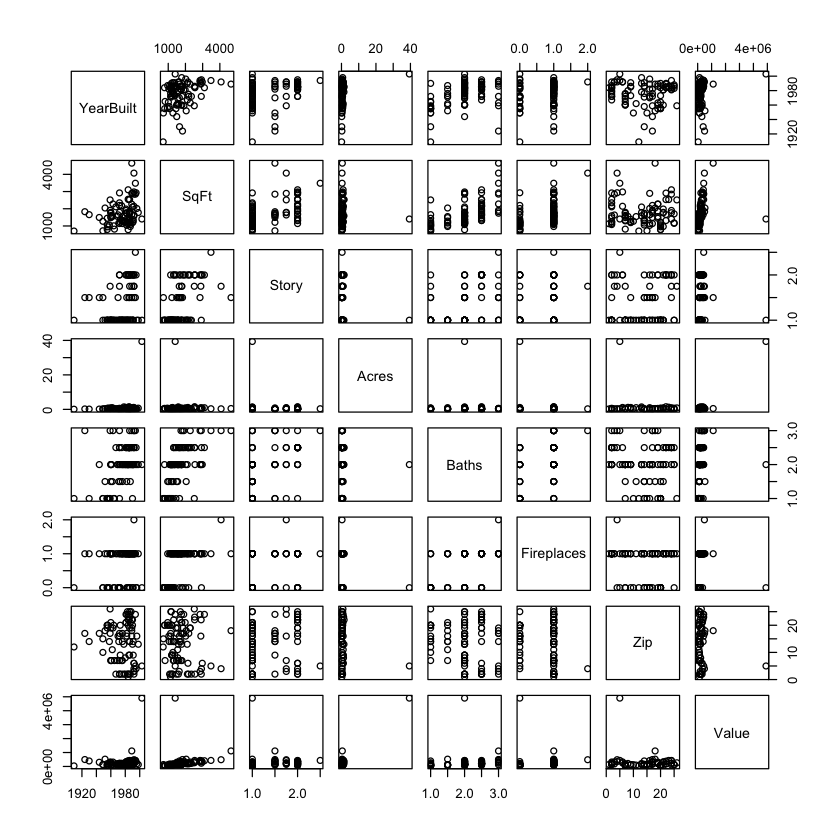

In [5]:
pairs(data)

* Ridge regression analysis


In [6]:
library(glmnet)
set.seed(1)
trainIdx = sample(1:nrow(data), round(nrow(data)*3/4, 0))
testIdx = (-trainIdx)

x.train = model.matrix(Value~., data=data[trainIdx,])
x.test = model.matrix(Value~., data=data[testIdx,])
y.train = data[trainIdx,]$Value
y.test = data[testIdx,]$Value

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



In [7]:
head(x.train)
head(y.train)

,(Intercept),YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Zip27511,Zip27513,Zip27518,⋯,Zip27607,Zip27608,Zip27609,Zip27610,Zip27612,Zip27613,Zip27614,Zip27615,Zip27616,Zip27617
24,1,1961,1620,1,0.61,2.0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
34,1,1971,1168,1,0.20,1.5,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
51,1,1987,1080,1,0.30,2.0,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
80,1,1981,1764,1,0.66,2.0,1,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
18,1,1959,1911,1,0.28,3.0,1,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
77,1,1960,1740,1,0.47,2.0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 128105 127708 159332 320419 318360  92749

In [8]:
# selection of the lambda by cross validation
grid = 10^seq(10, -2, length=100)
ridge.mod = cv.glmnet(x.train, y.train, alpha=0, lambda=grid,
                     thresh=1e-12)
lambda.best = ridge.mod$lambda.min
lambda.best

[1] 0.01321941

In [9]:
ridge.pred = predict(ridge.mod, newx=x.test, s=lambda.best)
1-mean((ridge.pred-y.test)^2)/mean((mean(y.test)-y.test)^2)
mean((ridge.pred-y.test)^2)

[1] 0.5254531

[1] 458905796059

In [10]:
predict(ridge.mod, newx=x.test, s=lambda.best, type='coefficients')

33 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) 2548408.5747
(Intercept)       .     
YearBuilt     -1297.8896
SqFt            144.2274
Story          7236.8834
Acres         41685.9925
Baths        -17483.2259
Fireplaces    21709.1798
Zip27511     -57240.6886
Zip27513     -38886.6774
Zip27518     -48082.9221
Zip27519     -32603.1297
Zip27526     -79413.9783
Zip27529     -94933.5305
Zip27539          .     
Zip27545     -52646.7529
Zip27560     -77667.7577
Zip27562    -172906.9138
Zip27601    -127015.9019
Zip27603     -90427.0974
Zip27604      -3637.9625
Zip27605      20657.6569
Zip27606     -49457.2747
Zip27607      55296.3770
Zip27608     334526.7021
Zip27609     -27325.6438
Zip27610     -62055.4211
Zip27612      49745.5579
Zip27613     -17227.9731
Zip27614      50052.5192
Zip27615      -8908.8567
Zip27616     -42578.3400
Zip27617    -157169.1059